In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime


In [9]:
# Load merged stock sentiment data for TSLA, AAPL, and AMZN
stock_files = {'TSLA': 'TSLA_merged_data.csv', 'AAPL': 'AAPL_merged_data.csv', 'AMZN': 'AMZN_merged_data.csv'}
stock_data = {stock: pd.read_csv(file) for stock, file in stock_files.items()}

# Ensure the 'Close' column exists and is properly parsed
for stock, df in stock_data.items():
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure date parsing
    print(f"Loaded {stock} data with {len(df)} rows.")


Loaded TSLA data with 252 rows.
Loaded AAPL data with 252 rows.
Loaded AMZN data with 252 rows.


C:\Users\AFFAN\AppData\Local\Temp\ipykernel_13500\2910079502.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure date parsing
C:\Users\AFFAN\AppData\Local\Temp\ipykernel_13500\2910079502.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure date parsing
C:\Users\AFFAN\AppData\Local\Temp\ipykernel_13500\2910079502.py:7: FutureWarning: In a future ve

In [28]:
# Hyperparameters
sequence_length = 30
batch_size = 8
epochs = 100
learning_rate = 0.001
hidden_dim = 128
num_layers = 2

# Define LSTM Model
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Use the output of the last time step
        return out


In [29]:
data_loaders = {}
scalers = {}

for stock, df in stock_data.items():
    # Scale 'Close' prices
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Scaled_Close'] = scaler.fit_transform(df[['Close']])
    scalers[stock] = scaler

    # Prepare sequences
    close_prices = df['Scaled_Close'].values
    sequences = []
    targets = []
    for i in range(len(close_prices) - sequence_length):
        sequences.append(close_prices[i:i + sequence_length])
        targets.append(close_prices[i + sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)

    # Convert to PyTorch tensors
    x_tensor = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    y_tensor = torch.tensor(targets, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(x_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    data_loaders[stock] = {'train_loader': train_loader, 'test_loader': test_loader}


In [30]:
models = {}
for stock in stock_files.keys():
    print(f"Training model for {stock}...")
    model = StockPredictor(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = data_loaders[stock]['train_loader']
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")
    models[stock] = model


Training model for TSLA...
Epoch 10/100, Train Loss: 0.0100
Epoch 20/100, Train Loss: 0.0051
Epoch 30/100, Train Loss: 0.0043
Epoch 40/100, Train Loss: 0.0038
Epoch 50/100, Train Loss: 0.0056
Epoch 60/100, Train Loss: 0.0036
Epoch 70/100, Train Loss: 0.0032
Epoch 80/100, Train Loss: 0.0033
Epoch 90/100, Train Loss: 0.0030
Epoch 100/100, Train Loss: 0.0030
Training model for AAPL...
Epoch 10/100, Train Loss: 0.0088
Epoch 20/100, Train Loss: 0.0071
Epoch 30/100, Train Loss: 0.0059
Epoch 40/100, Train Loss: 0.0050
Epoch 50/100, Train Loss: 0.0043
Epoch 60/100, Train Loss: 0.0041
Epoch 70/100, Train Loss: 0.0069
Epoch 80/100, Train Loss: 0.0048
Epoch 90/100, Train Loss: 0.0043
Epoch 100/100, Train Loss: 0.0040
Training model for AMZN...
Epoch 10/100, Train Loss: 0.0082
Epoch 20/100, Train Loss: 0.0050
Epoch 30/100, Train Loss: 0.0037
Epoch 40/100, Train Loss: 0.0032
Epoch 50/100, Train Loss: 0.0031
Epoch 60/100, Train Loss: 0.0028
Epoch 70/100, Train Loss: 0.0056
Epoch 80/100, Train Loss: 

In [31]:
for stock, model in models.items():
    print(f"Evaluating model for {stock}...")
    test_loader = data_loaders[stock]['test_loader']
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(y_batch.tolist())
    
    # Denormalize predictions and actuals
    scaler = scalers[stock]
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    # Debugging output
    print(f"{stock} - Denormalized Predictions (first 5): {predictions[:5]}")
    print(f"{stock} - Denormalized Actuals (first 5): {actuals[:5]}")

    # Save predictions and actuals for plotting
    stock_data[stock]['Predictions'] = np.nan
    stock_data[stock].iloc[-len(predictions):, stock_data[stock].columns.get_loc('Predictions')] = predictions


Evaluating model for TSLA...
TSLA - Denormalized Predictions (first 5): [292.96307568 356.19787443 275.78982735 236.84055431 306.10541261]
TSLA - Denormalized Actuals (first 5): [297.99999931 364.64666734 281.01000791 213.10000593 292.11666606]
Evaluating model for AAPL...
AAPL - Denormalized Predictions (first 5): [170.53347154 172.40590048 147.51564638 160.10766726 156.46691189]
AAPL - Denormalized Actuals (first 5): [167.06335507 171.52038632 146.85653631 159.01519769 152.43020578]
Evaluating model for AMZN...
AMZN - Denormalized Predictions (first 5): [165.28715849 177.0731352  145.21960524 118.93268774 142.67486896]
AMZN - Denormalized Actuals (first 5): [161.21400308 177.44999604 151.35799935 115.54000105 139.41000371]


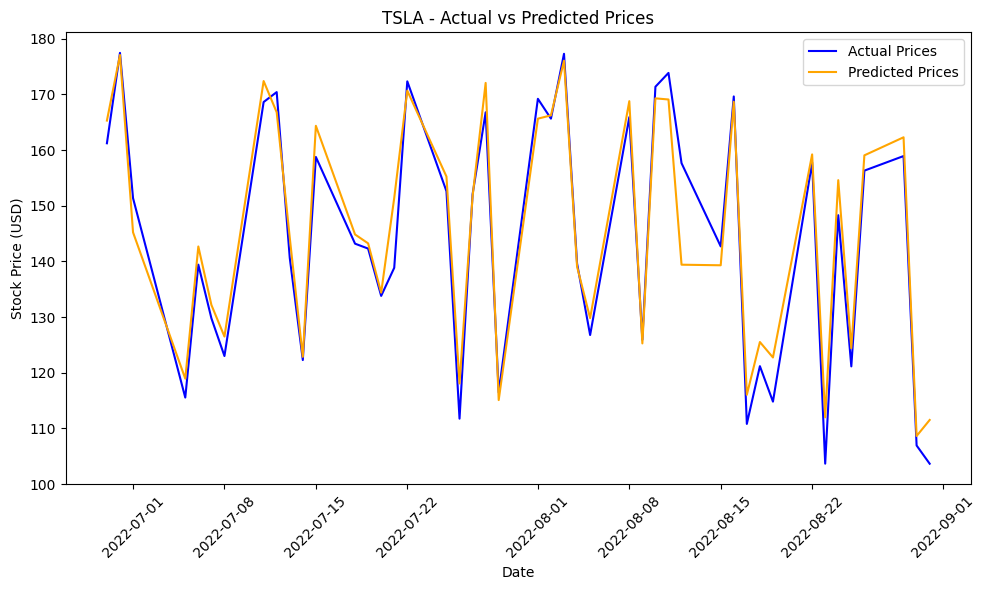

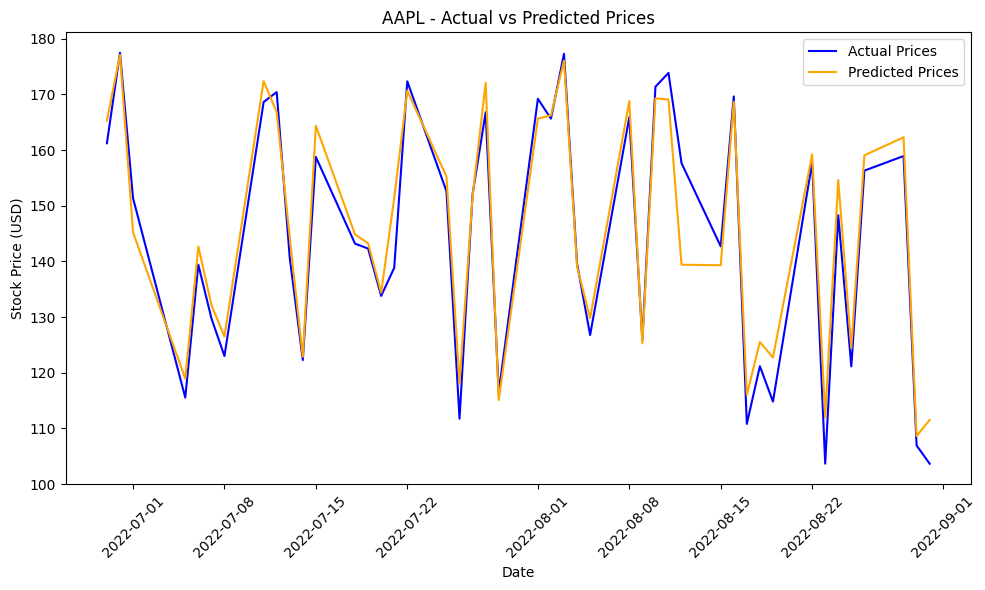

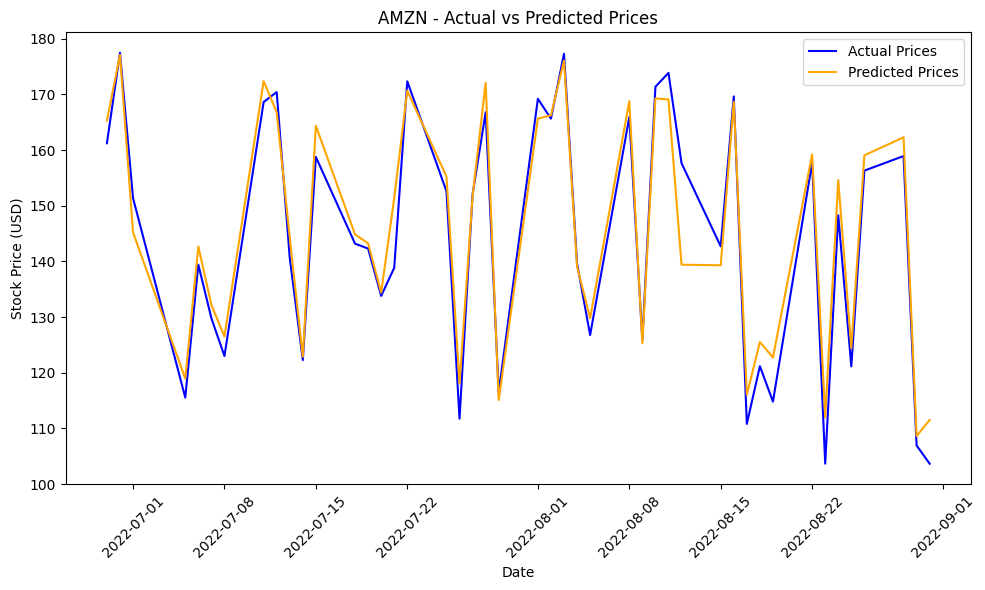

In [32]:
for stock, df in stock_data.items():
    plt.figure(figsize=(10, 6))
    dates = df['Date'][-len(predictions):]
    plt.plot(dates, actuals, label="Actual Prices", color='blue')
    plt.plot(dates, predictions, label="Predicted Prices", color='orange')
    plt.title(f"{stock} - Actual vs Predicted Prices")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
